In [1]:
import tensorflow_datasets as tfds

In [5]:
import tensorflow as tf

In [3]:
import tensorflow_text as text

In [6]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)

In [7]:
metadata.features, metadata.splits

(Translation({
     'en': Text(shape=(), dtype=string),
     'pt': Text(shape=(), dtype=string),
 }),
 {'train': <SplitInfo num_examples=51785, num_shards=1>,
  'validation': <SplitInfo num_examples=1193, num_shards=1>,
  'test': <SplitInfo num_examples=1803, num_shards=1>})

In [7]:
train_examples, val_examples, test_examples = examples['train'], examples['validation'], examples["test"]

In [ ]:
for pt_examples, en_examples in train_examples.batch(4).take(1):
    for pt, en in zip(pt_examples.numpy(), en_examples.numpy()):
        print(pt.decode(), "\n", en.decode(), "\n")

e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade . 
 and when you improve searchability , you actually take away the one advantage of print , which is serendipity . 

mas e se estes fatores fossem ativos ? 
 but what if it were active ? 

mas eles não tinham a curiosidade de me testar . 
 but they did n't test for curiosity . 

e esta rebeldia consciente é a razão pela qual eu , como agnóstica , posso ainda ter fé . 
 and this conscious defiance is why i , as an agnostic , can still have faith . 



In [ ]:
tf.keras.utils.get_file(
    'ted_hrlr_translate_pt_en_converter.zip',
    'https://storage.googleapis.com/download.tensorflow.org/models/ted_hrlr_translate_pt_en_converter.zip',
    cache_dir='.', cache_subdir='', extract=True
)

184801/184801 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step


'./ted_hrlr_translate_pt_en_converter_extracted'

In [8]:
model_path = "/home/fs/ML/Ipynbs/DL/ted_hrlr_translate_pt_en_converter_extracted/ted_hrlr_translate_pt_en_converter"

In [9]:
tokenizers = tf.saved_model.load(model_path)

In [ ]:
for _, en_examples in train_examples.batch(3).take(1):
    encoded = tokenizers.en.tokenize(en_examples)
    decoded = tokenizers.en.detokenize(encoded)

    for enc, dec in zip(encoded.numpy(), decoded.numpy()):
        print(enc, "\n", dec.decode(), "\n")

[   2   72  117   79 1259 1491 2362   13   79  150  184  311   71  103
 2308   74 2679   13  148   80   55 4840 1434 2423  540   15    3] 
 and when you improve searchability , you actually take away the one advantage of print , which is serendipity . 

[   2   87   90  107   76  129 1852   30    3] 
 but what if it were active ? 

[   2   87   83  149   50    9   56  664   85 2512   15    3] 
 but they did n ' t test for curiosity . 



In [10]:
import numpy as np

In [12]:
import matplotlib.pyplot as plt

In [15]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
    pt_tokens = tokenizers.pt.tokenize(pt_examples)
    lengths.append(pt_tokens.row_lengths())

    en_tokens = tokenizers.en.tokenize(en_examples)
    lengths.append(en_tokens.row_lengths())
    print('.', end='', flush=True)

...................................................

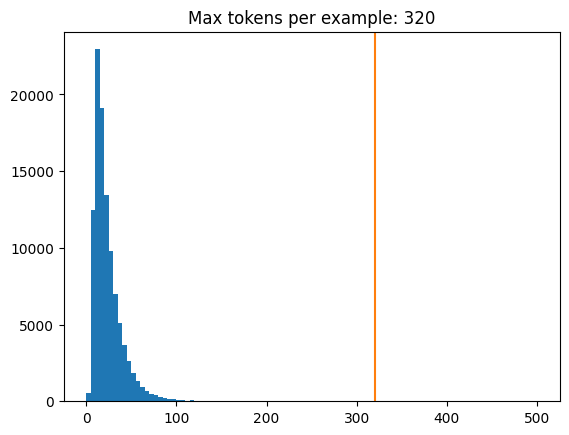

In [16]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Max tokens per example: {max_length}');

In [11]:
MAX_TOKENS = 128
BUFFER_SIZE = 1000
BATCH_SIZE = 256

In [13]:
def prepare_batch_optimized(pt, en):
    @tf.function
    def tokenize_and_process(pt, en):
        pt = tokenizers.pt.tokenize(pt)
        pt = pt[:, :MAX_TOKENS]
        pt = pt.to_tensor()

        en = tokenizers.en.tokenize(en)
        en = en[:, :(MAX_TOKENS+1)]
        
        en_inputs = en[:, :-1].to_tensor() # Викидуємо [END] токен
        en_labels = en[:, 1:].to_tensor() #  Викидуємо [START] токен
        
        return (pt, en_inputs), en_labels
    
    return tokenize_and_process(pt, en)

def make_batches_optimized(dataset, shuffle_data=False):
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
    options.experimental_optimization.map_parallelization = True
    options.experimental_optimization.map_and_batch_fusion = True
    options.experimental_optimization.noop_elimination = True
    
    if shuffle_data:
        dataset = (
            dataset
            .shuffle(BUFFER_SIZE)
            .batch(BATCH_SIZE)
            .map(prepare_batch_optimized, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(buffer_size=tf.data.AUTOTUNE)
            .with_options(options)
        )
    else:
        dataset = (
            dataset
            .batch(BATCH_SIZE)
            .map(prepare_batch_optimized, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(buffer_size=tf.data.AUTOTUNE)
            .with_options(options)
        )
    
    return dataset

In [14]:
train_batches = make_batches_optimized(train_examples, shuffle_data=True)
val_batches = make_batches_optimized(val_examples, shuffle_data=False)

In [25]:
batch_index = 0
bugs_num = 0

for batch in train_batches:
    (pt, en_inputs), en_labels = batch

    for idx in range(64):
        if idx < len(pt):
            pt_tokens = pt[idx].numpy()

            if not any(token == 0 for token in pt_tokens) and pt_tokens[-1] != 3:
                bugs_num += 1
    
    batch_index += 1

print(bugs_num)

101


In [15]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]
    depths = np.arange(depth)[np.newaxis, :]/depth

    angle_rates = 1 / (10000**depths)
    angle_rads = positions * angle_rates

    pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

In [16]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, emb_dim):
        super().__init__()
        self.emb_dim = emb_dim
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=emb_dim, mask_zero=True) 
        self.pos_encoding = positional_encoding(length=2048, depth=emb_dim)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # Sets the relative scale
        x *= tf.math.sqrt(tf.cast(self.emb_dim, tf.float32))
        x += self.pos_encoding[tf.newaxis, :length, :]
        
        return x

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

In [17]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layer_norm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

In [18]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output = self.mha(
        query=x,
        key=context,
        value=context)

    x = self.add([x, attn_output])
    x = self.layer_norm(x)

    return x
  
# x – це вхідні дані декодера (вектор query). Вони беруться з попереднього шару декодера.
# context – це вихід із енкодера (вектори "key" та "value").

# Енкодер: Він приймає вхідну послідовність (наприклад, запит користувача) та перетворює її у внутрішнє представлення. 
# Це представлення містить важливу інформацію про всі елементи вхідних даних. 
# Його передають як ключі (key) і значення (value), тому що вони слугують як база даних для пошуку релевантної інформації.

# Декодер: Він формує запит (query) на основі свого поточного стану (наприклад, попередньо згенерованих слів) 
# використовує його для обчислення уваги по даних з енкодера.

In [19]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    
    x = self.add([x, attn_output])
    x = self.layer_norm(x)
    
    return x

In [20]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask=True)
    
    x = self.add([x, attn_output])
    x = self.layer_norm(x)

    return x

In [21]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, emb_dim, dff, dropout_rate=0.1):
    super().__init__()
    self.seq_model = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(emb_dim),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq_model(x)])
    x = self.layer_norm(x) 

    return x

In [22]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, *, emb_dim, num_heads, dff, dropout_rate=0.1):
    super().__init__()
    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=emb_dim,
        dropout=dropout_rate)
    self.ffn = FeedForward(emb_dim=emb_dim, dff=dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    
    return x

In [23]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, emb_dim, num_heads, dff, vocab_size, dropout_rate=0.1):
    super().__init__()
    self.emb_dim = emb_dim
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, emb_dim=emb_dim)
    self.enc_layers = [
        EncoderLayer(emb_dim=emb_dim,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    x = self.pos_embedding(x)  # (batch_size, seq_len, emb_dim)
    x = self.dropout(x)

    # Послідовно обробляємо дані, передаючи вихід одного шару на вхід наступного.
    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x

In [24]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, *, emb_dim, num_heads, dff, dropout_rate=0.1):
    super().__init__()
    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=emb_dim,
        dropout=dropout_rate)
    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=emb_dim,
        dropout=dropout_rate)
    self.ffn = FeedForward(emb_dim=emb_dim, dff=dff)

  def call(self, x, context):
    x = self.causal_self_attention(x)
    x = self.cross_attention(x, context)
    x = self.ffn(x)

    return x

In [25]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, emb_dim, num_heads, dff, vocab_size, dropout_rate=0.1):
    super().__init__()
    self.emb_dim = emb_dim
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, emb_dim=emb_dim)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(emb_dim=emb_dim, 
                     num_heads=num_heads,
                     dff=dff, 
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]

  def call(self, x, context):
    x = self.pos_embedding(x)
    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    return x

In [26]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, emb_dim, num_heads, dff, input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, emb_dim=emb_dim,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)
    self.decoder = Decoder(num_layers=num_layers, emb_dim=emb_dim,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # context - вхідні речення португальською мовою (індекси токенів) - для енкодеру
    # x - цільові речення англійською мовою (індекси токенів) - для декодеру
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, emb_dim)
    x = self.decoder(x, context)  # (batch_size, target_len, emb_dim)
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    # Короткі речення з великою кількістю паддінгу отримують більший внесок від паддінгових позицій
    # Тому видаляємо маску тільки з фінальних логітів, після того як усі обчислення уваги вже завершено
    try:
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [27]:
num_layers = 1
emb_dim = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [28]:
transformer = Transformer(
    num_layers=num_layers,
    emb_dim=emb_dim,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

In [29]:
transformer.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Encoder)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Decoder)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [30]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, emb_dim, warmup_steps=4000):
    super().__init__()
    self.emb_dim = tf.cast(emb_dim, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.emb_dim) * tf.math.minimum(arg1, arg2)

In [31]:
learning_rate = CustomSchedule(emb_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [32]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)

  return loss

In [33]:
def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)

  return tf.reduce_sum(match) / tf.reduce_sum(mask)

In [45]:
checkpoint_path = 'transformer.weights.h5'

class SaveEveryNSteps(tf.keras.callbacks.Callback):
    def __init__(self, save_freq=20, filepath=checkpoint_path):
        super(SaveEveryNSteps, self).__init__()
        self.save_freq = save_freq
        self.filepath = filepath
        self.steps = 0
    
    def on_batch_end(self, batch, logs=None):
        self.steps += 1
        if self.steps % self.save_freq == 0:
            self.model.save_weights(self.filepath, overwrite=True)

In [46]:
save_callback = SaveEveryNSteps(save_freq=20)

In [36]:
transformer.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])

In [ ]:
transformer.fit(train_batches, epochs=1, validation_data=val_batches, callbacks=[save_callback])

In [39]:
transformer.build([(None, None), (None, None)])  # (batch_size, sequence_length) для обох входів
transformer.load_weights(checkpoint_path)

In [40]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      predictions = predictions[:, -1:, :]

      predicted_id = tf.argmax(predictions, axis=-1)

      output_array = output_array.write(i + 1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    text = tokenizers.en.detokenize(output)[0]

    tokens = tokenizers.en.lookup(output)[0]

    self.transformer([encoder_input, output[:,:-1]], training=False)

    return text, tokens

In [41]:
translator = Translator(tokenizers, transformer)

In [42]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [44]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : simulationade sensitive light elephant elephant visitors visitors visitors substance diameter go gulf happen disappeared collaborators implications majoritywing light thus novel clever facilities thus novel manipulate investigation broke ceiling likely likely likelyvation tumor transactions clock engaging account addingunk years closer closer closer affects cause lightrap shares plainunkunkunkunkunkugh steel independence wealthyugh engagement profileborn featureunk relate spaces vocalrable smarter was was goes reserve responds spaces pathway angles smarteraid primates flexible obama flexible you taking primates primates primates orbit orbit orbit primates primates primates primatespressed orbit orbit sexting pizza super lettingnana cold orbit chemical orbitv choosingoe are cute cute cute cute abstractographicoeographic cute cute outside egyptians regimewing
Ground truth   : this is a problem we have to solve .